# Rede Neural

## Resumo dos resultados dessa etapa

Uma rede neural simples foi ajustada aos modelos.

A escolha do formato simples foi motivada pelo numero relativamente baixo de observações para esse tipo de modelo.

Durante essa execução, o modelo atingiu uma acurácia média de 76%.

**Disclaimer**

O processo de otimização da rede é não determinístico. Isso significa que os resultados dependem de processos aleatórios e, sem fixação de parâmetros de aleatoriedade, podem variar entre execuções.

O código abaixo pode ser utilizado para realizar essa fixação e garantir reprodutibilidade.

```python
from tensorflow.random import set_seed
set_seed(42)
```

Os resultados descritos na versão impressa do estudo não cosideraram uma semente.

Reproduzimos abaixo o código utilizado para obtenção daquele modelo.

## Detalhamento da etapa

### Imports

In [11]:
import requests
from io import BytesIO
import joblib
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from keras.utils.vis_utils import plot_model

from ann_visualizer.visualize import ann_viz

from sklearn.metrics import classification_report

from random import seed, choice

import lime
import lime.lime_tabular

import eli5
import shap
shap.initjs()

In [2]:
def load_remote_joblib(url):
    """função utilizada para carregar joblib de fonte remota
    ESSAfeature_namesCAO É PERIGOSA
    a função joblib.load pode executar código arbitrário durante sua execuççao
    não utilize essa parte do código se você não tiver certeza do que está fazendo
    """
    content = requests.get(url).content
    return joblib.load(BytesIO(content))
    

x_scaler = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/x_scaler.joblib")
scaled_X = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/scaled_X.joblib")

y_scaler = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/y_scaler.joblib")
scaled_y = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/scaled_y.joblib")

feature_names = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/features.joblib")
categories = load_remote_joblib("https://github.com/odxone/imil_agro_anexo/raw/main/nbs/data_gini/categories.joblib")

### Tunning

O número de observações é baixo para esse tipo de modelo.

Mantivemos o desenho da rede simples para diminuir a complexidade e testamos essa configuração.

## Definição da Rede

In [3]:
def baseline_model():
    model = Sequential()
    model.add(Dense(10,
                    input_dim=39,
                    kernel_initializer='normal',
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))
    
    model.compile(
        loss='BinaryCrossentropy',
        metrics=['accuracy'],
        optimizer='adam'
    )
    
    return model

In [4]:
baseline_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                400       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 411
Trainable params: 411
Non-trainable params: 0
_________________________________________________________________


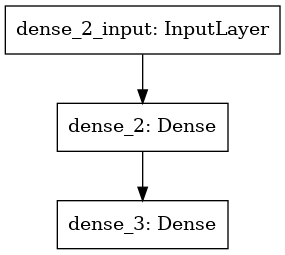

In [5]:
plot_model(baseline_model())

## Treinamento Rede

In [51]:
nn_model = KerasClassifier(
    baseline_model,
    epochs=500,
    batch_size=3,
    verbose=0
)

In [52]:
nn_model.fit(scaled_X, scaled_y)

A célula abaixo gera um arquivo `.gv`e um `.pdf`. Os arquivos estão 

In [ ]:
#ann_viz(baseline_model(), filename='rede_2_categs.gv', view=True, title='Rede Neural - 2 categorias')

## Performance

In [53]:
prediction = nn_model.predict(scaled_X)

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [54]:
print(
    classification_report(
        scaled_y,
        prediction, 
        target_names=categories
    )
)

              precision    recall  f1-score   support

   gini_alto       0.76      0.75      0.76      2779
  gini_baixo       0.75      0.76      0.76      2781

    accuracy                           0.76      5560
   macro avg       0.76      0.76      0.76      5560
weighted avg       0.76      0.76      0.76      5560



In [55]:
nn_model.model.save('data_gini/nn_estimator/')

INFO:tensorflow:Assets written to: data_gini/nn_estimator/assets


## Interpretabilidade

In [57]:
seed(42)

random_obs_idx = choice(range(len(scaled_X)))

random_obs = scaled_X[random_obs_idx]

Os modelos do tipo rede neural podem atingir alta acurácia mas, via de regra, são notoriamente difíceis de interpretar.

Mesmo os modelos mais simples podem atingir números de parâmetros bastante elevados e as relações entre esses parâmetros e os outputs ainda são modificados por outros fatores, como as funções de ativação.

Para abordar essa fragilidade, aplicamos os algorítimos LIME, em uma observação, e o SHAP, em 100 observaçoes, utilizando modelo obtido.

### LIME

In [61]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=scaled_X,
    feature_names=feature_names,
    class_names=categories,
    mode='classification'
)

lime_exp_nn = explainer.explain_instance(
    random_obs,
    nn_model.predict_proba,
)

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


In [62]:
lime_exp_nn.show_in_notebook()

### SHAP

In [63]:
shap_nn_expainer = shap.KernelExplainer(
    nn_model.predict_proba,
    shap.sample(scaled_X, random_state=42)
)

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.


In [64]:
shap_nn_values = shap_nn_expainer.shap_values(shap.sample(scaled_X, random_state=42))

  0%|          | 0/100 [00:00<?, ?it/s]

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `

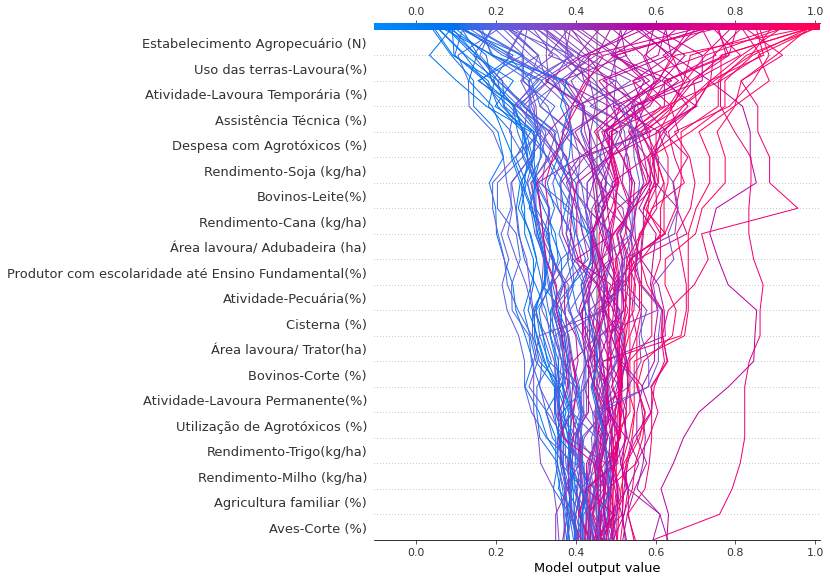

In [65]:
shap.decision_plot(
    shap_nn_expainer.expected_value[0],
    shap_nn_values[0],
    feature_names=feature_names
)

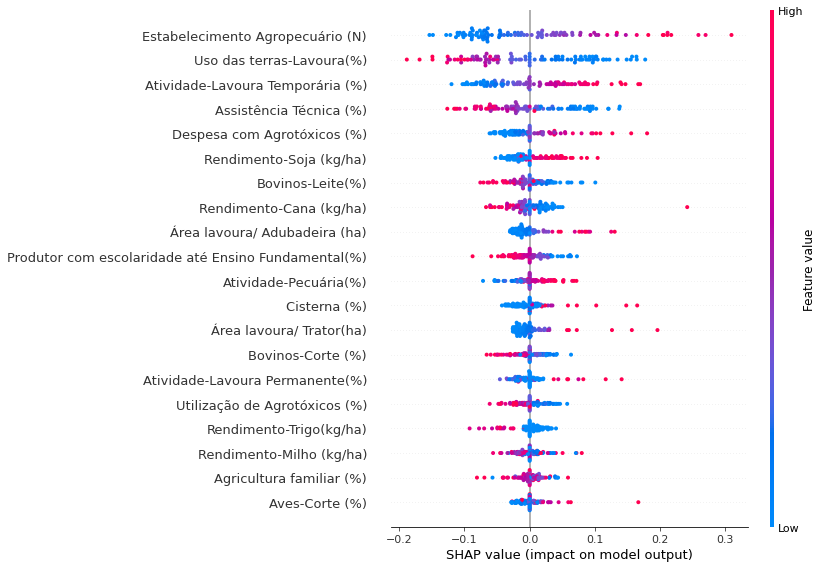

In [66]:
shap.summary_plot(
    shap_nn_values[0],
    features=shap.sample(scaled_X, random_state=42),
    feature_names=feature_names
)